### Metro Nashville Emergency Communications

#### Snickers: Hypothesis: tie between economic status in NW region of Davidson and number of calls received, specifically lack of calls. Very few calls from northwest region of Davidson. Correlate income per zipcode with calls for each storm.

In [1]:
import pandas as pd
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
derecho_calls=pd.read_csv("../data/911_Phone Calls_Derecho_050320 050420.csv")
derecho_calls.head(3)

,Seizure DateTime,CallTypeId,ALI Latitude,ALI Longitude,Cell Tower Address
0,5/3/2020 16:30,911 Calls,36.247802,-86.716847,WIRELESS CALLER
1,5/3/2020 16:30,911 Calls,36.143108,-86.800621,1161 21ST AV S - SE
2,5/3/2020 16:30,911 Calls,36.100516,-87.056329,8013 C MCCRORY LN - N


In [3]:
tornado_calls=pd.read_csv("../data/911_Phone_Calls_Tornado_030320.csv")
tornado_calls.head(3)

,Seizure DateTime,CallTypeId,ALI Latitude,ALI Longitude,Cell Tower Address
0,3/3/2020 0:34,911 Calls,36.072708,-86.665779,620 Richards RD - N Sector
1,3/3/2020 0:36,911 Calls,36.159634,-86.841904,4507D KENTUCKY AV - SE
2,3/3/2020 0:36,911 Calls,36.264153,-86.708862,329 THELMA ST - S Sector


In [4]:
derecho_cad=pd.read_csv("../data/Computer Aided Dispatch Data_Derecho Incidents 050320-050420.csv", skiprows=3)
derecho_cad.head(3)

,IncidentDate,Location,Latitude1,Longitude1,IncidentTypeDescription1
0,5/3/2020 4:31:07 PM,901 KENWICK CT W,36.046877,-86.962526,ELECTRICAL HAZARD
1,5/3/2020 4:32:18 PM,8036 ARBOR DR,36.082491,-86.940680,ELECTRICAL HAZARD
2,5/3/2020 4:32:23 PM,119 DUE WEST AV E,36.248029,-86.716875,NOT ALERT COPD


In [5]:
tornado_cad=pd.read_csv("../data/Computer Aided Dispatch Data_Tornado Incidents 030320.csv", skiprows=3)
tornado_cad.head(3)

,IncidentDate,Location,Latitude1,Longitude1,IncidentTypeDescription1
0,3/3/2020 12:36:34 AM,6205 COCKRILL BEND CIR,36.182002,-86.894052,GENERAL ALARM COMMERCIAL INDUSTRIAL BUILD
1,3/3/2020 12:37:24 AM,7337 COCKRILL BEND BLVD,36.175666,-86.894978,GENERAL ALARM COMMERCIAL INDUSTRIAL BUILD
2,3/3/2020 12:38:17 AM,110 TUNE AIRPORT DR,36.179299,-86.883727,STRUCTURE FIRE COMMERCIAL INDUSTRIAL


In [6]:
tornado_calls.columns = ['datetime', 'calltype','lat','lng','address']

In [7]:
derecho_cad.columns = ['datetime', 'calltype','lat','lng','alarm']

In [8]:
tornado_cad.columns = ['datetime', 'calltype','lat','lng','alarm']

In [9]:
derecho_calls.columns = ['datetime', 'calltype','lat','lng','address']

#### Timeline of each storm/ Beginning and end of the event
Tornado calls: 3/3/2020 12:34am-4:58am

Tornado cad: 12:36am-4:57am

Derecho calls: 5/3/2020 4:30pm- 5/4/2020 12:29am

Derecho cad: 4:31pm-12:29am

#### Stonger storm impact based no call volumes/Locations of heaviest storm impact based on call volume
Tornado Calls:
    Datetime - 
            12:43am= 12 calls           
            12:58am and 12:59am = 11 calls         
    Address - 
        Wireless caller                     101     
        907 12th av n-n                     16     
        1051G Chicamauga Ave - S            10     
        3333 Lebanon Pike - SE              8       
        4940 Old Hickory BLVD. - SE SECTOR  7
    
Tornado CAD: 
    Datetime- 3/3/2020 
            12:47:35 AM   2
            1:28:24 AM    2
            1:15:14 AM    2
            12:44:02 AM   2
            2:04:00 AM    2
    Alarm-
            GENERAL ALARM COMMERCIAL   INDUSTRIAL BUILD      27
            OUTSIDE ODOR                                     26
            WIRES DOWN WITH NO SMOKE OR ARCING               17
            SMALL BUILDING INVESTIGATION                     15
            ELECTRICAL HAZARD WITH OR NEAR WATER             12
Derecho Calls:
     Datetime- 
             5/3/2020 18:58    12
             5/3/2020 16:36    12
             5/3/2020 18:48    11
             5/3/2020 18:04    11
             5/3/2020 17:19    10
     Address-
            WIRELESS CALLER                339
            4400 HARDING PIKE - E           15
            3333 LEBANON PIKE - N           14
            WIRELESS 911 CALLER             14
            3009D DARRINGTON WAY - N        14    
Derecho CAD:
      Datetime-
             5/3/2020 7:48:02 PM     2
             5/3/2020 7:16:05 PM     2
             5/3/2020 9:39:26 PM     2
             5/3/2020 6:35:07 PM     2
             5/3/2020 9:29:25 PM     2
       Alarm-
           ELECTRICAL HAZARD                                370
           GENERAL ALARM COMMERCIAL   INDUSTRIAL BUILD       23
           MVA INJURIES:                                      8
           SMALL BUILDING INVESTIGATION                       6
           SMALL OUTSIDE FIRE                                 6  

In [10]:
derecho_calls['geometry'] = derecho_calls.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)

In [11]:
tornado_calls['geometry'] = tornado_calls.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)

In [12]:
tornado_cad['geometry'] = tornado_cad.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)

In [13]:
derecho_cad['geometry'] = derecho_cad.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
derecho_cad.head(3)

,datetime,calltype,lat,lng,alarm,geometry
0,5/3/2020 4:31:07 PM,901 KENWICK CT W,36.046877,-86.962526,ELECTRICAL HAZARD,POINT (-86.96252641 36.04687715)
1,5/3/2020 4:32:18 PM,8036 ARBOR DR,36.082491,-86.940680,ELECTRICAL HAZARD,POINT (-86.94067952 36.08249081)
2,5/3/2020 4:32:23 PM,119 DUE WEST AV E,36.248029,-86.716875,NOT ALERT COPD,POINT (-86.71687484 36.24802948)


In [14]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
print(zipcodes.crs)
zipcodes.head(2)

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."


In [15]:
zipcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
tornado_calls_geo = gpd.GeoDataFrame(tornado_calls, 
                           crs = zipcodes.crs, 
                           geometry = tornado_calls['geometry'])
type(tornado_calls_geo)

geopandas.geodataframe.GeoDataFrame

In [17]:
derecho_calls_geo = gpd.GeoDataFrame(derecho_calls, 
                           crs = zipcodes.crs, 
                           geometry = derecho_calls['geometry'])
type(derecho_calls_geo)

geopandas.geodataframe.GeoDataFrame

In [18]:
tornado_cad_geo = gpd.GeoDataFrame(tornado_cad, 
                           crs = zipcodes.crs, 
                           geometry = tornado_cad['geometry'])
type(tornado_cad_geo)

geopandas.geodataframe.GeoDataFrame

In [19]:
derecho_cad_geo = gpd.GeoDataFrame(derecho_cad, 
                           crs = zipcodes.crs, 
                           geometry = derecho_cad['geometry'])
type(derecho_cad_geo)

geopandas.geodataframe.GeoDataFrame

In [20]:
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]

In [54]:
tornado_calls_zip = gpd.sjoin(tornado_calls_geo, zipcodes, op = 'within')
tornado_calls_zip=tornado_calls_zip.reset_index(drop = True)
tornado_calls_zip.head(2)

,datetime,calltype,lat,lng,address,geometry,index_right,zip,po_name
0,3/3/2020 0:34,911 Calls,36.072708,-86.665779,620 Richards RD - N Sector,POINT (-86.66578 36.07271),51,37013,ANTIOCH
1,3/3/2020 0:38,911 Calls,36.052055,-86.648331,745 BELL RD - OMNI Sector,POINT (-86.64833 36.05205),51,37013,ANTIOCH


In [22]:
tornado_cad_zip = gpd.sjoin(tornado_cad_geo, zipcodes, op = 'within')

In [23]:
derecho_calls_zip = gpd.sjoin(derecho_calls_geo, zipcodes, op = 'within')

In [24]:
derecho_cad_zip = gpd.sjoin(derecho_cad_geo, zipcodes, op = 'within')

In [25]:
nashville = (36.16784, -86.77816)

nash_map = folium.Map(location = nashville, zoom_start = 10)

In [26]:
new_map_tcalls = folium.Map(location =  nashville, zoom_start = 14)

marker_cluster = MarkerCluster().add_to(new_map_tcalls)

folium.GeoJson(zipcodes).add_to(marker_cluster)

for row_index, row_values in tornado_calls_zip.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['address']),row_values['calltype']
    icon=folium.Icon(color="red",icon="phone", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

#new_map_tcalls.save('../maps/tornado_calls_nash.html')

#new_map_tcalls  

In [27]:
new_map_tcad = folium.Map(location =  nashville, zoom_start = 14)

marker_cluster = MarkerCluster().add_to(new_map_tcad)

folium.GeoJson(zipcodes).add_to(marker_cluster)

for row_index, row_values in tornado_cad_zip.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['alarm'])
    icon=folium.Icon(color="red",icon="phone", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

#new_map_tcad.save('../maps/tornado_cad_nash.html')

#new_map_tcad 

In [28]:
new_map_dcalls = folium.Map(location =  nashville, zoom_start = 14)

marker_cluster = MarkerCluster().add_to(new_map_dcalls)

folium.GeoJson(zipcodes).add_to(marker_cluster)

for row_index, row_values in derecho_calls_zip.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['zip']),row_values['calltype'],row_values['address']
    icon=folium.Icon(color="red",icon="phone", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
#new_map_dcalls.save('../maps/derecho_calls_nash.html')

#new_map_dcalls 

In [29]:
new_map_dcad = folium.Map(location =  nashville, zoom_start = 14)

marker_cluster = MarkerCluster().add_to(new_map_dcad)

folium.GeoJson(zipcodes).add_to(marker_cluster)

for row_index, row_values in derecho_cad_zip.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['alarm'])
    icon=folium.Icon(color="red",icon="phone", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
#new_map_dcad.save('../maps/derecho_cad_nash.html')

#new_map_dcad 

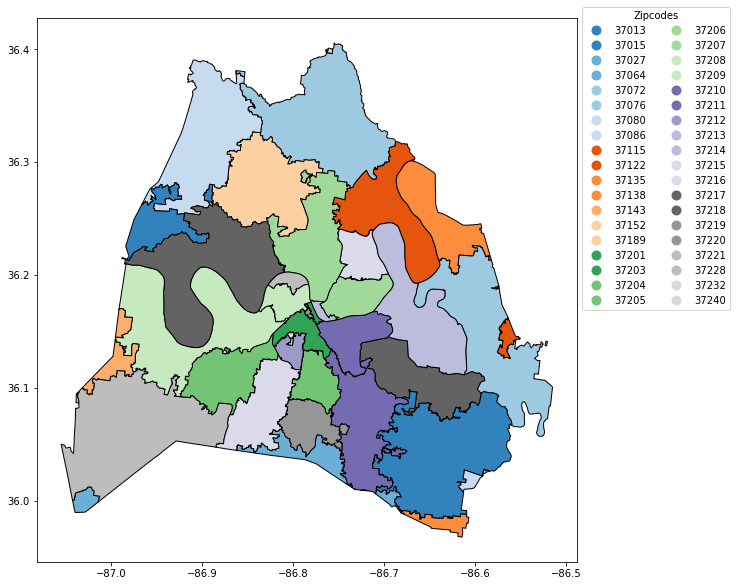

In [30]:
leg_kwds = {'title': 'Zipcodes', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

zipcodes.plot(column = 'zip', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'tab20c')
plt.show()

In [55]:
map_zipcodes = folium.Map(location =  nashville, zoom_start = 12)

folium.GeoJson(zipcodes).add_to(map_zipcodes)

for row_index, row_values in tornado_calls_zip.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['zip'])
    icon=folium.Icon(color="red",icon="phone", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(map_zipcodes)
    
#map_zipcodes.save('../maps/mapzipcodes.html')

#map_zipcodes

In [32]:
poly_zip=zipcodes[zipcodes['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
poly_zip=poly_zip.reset_index(drop = True)
poly_zip.shape

(11, 3)

In [33]:
tcalls_in_nw = tornado_calls_zip[tornado_calls_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
tcalls_in_nw=tcalls_in_nw.reset_index(drop = True)
tcalls_in_nw.shape

(43, 9)

In [34]:
tcad_in_nw = tornado_cad_zip[tornado_cad_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
tcad_in_nw=tcad_in_nw.reset_index(drop = True)
tcad_in_nw.shape

(13, 9)

In [35]:
dcalls_in_nw = derecho_calls_zip[derecho_calls_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
dcalls_in_nw=dcalls_in_nw.reset_index(drop = True)
dcalls_in_nw.shape

(78, 9)

In [36]:
dcad_in_nw = derecho_cad_zip[derecho_cad_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
dcad_in_nw=dcad_in_nw.reset_index(drop = True)
dcad_in_nw.head(2)

,datetime,calltype,lat,lng,alarm,geometry,index_right,zip,po_name
0,5/3/2020 4:49:46 PM,8495 SYCAMORE CREEK RD,36.387306,-86.896266,ELECTRICAL HAZARD,POINT (-86.89627 36.38731),20,37080,JOELTON
1,5/3/2020 4:54:59 PM,8655 WHITES CREEK PKE,36.384958,-86.897835,RESIDENTIAL FIRE,POINT (-86.89784 36.38496),20,37080,JOELTON


In [37]:
cluster_map_nw = folium.Map(location =  nashville, zoom_start = 12)

marker_cluster = MarkerCluster().add_to(cluster_map_nw)

folium.GeoJson(poly_zip).add_to(cluster_map_nw)

for row_index, row_values in dcalls_in_nw.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['address'])
    icon=folium.Icon(color="red",icon="phone", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
cluster_map_nw.save('../maps/clusternw.html')

cluster_map_nw  

In [38]:
cluster_map_nw = folium.Map(location =  nashville, zoom_start = 12)

marker_cluster = MarkerCluster().add_to(cluster_map_nw)

folium.GeoJson(poly_zip).add_to(cluster_map_nw)

for row_index, row_values in dcad_in_nw.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['alarm'])
    icon=folium.Icon(color="red",icon="phone", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
cluster_map_nw.save('../maps/clusternw.html')

cluster_map_nw 

In [ ]:
assist_app

In [39]:
assist_app = pd.read_csv('../data/PublicAssistanceApplicants.csv')

In [40]:
assist_app.columns = ['disasterNumber', 'applicantId', 'state', 'applicantName',
       'addressLine1', 'addressLine2', 'city', 'zipCode', 'hash',
       'lastRefresh', 'id']

In [41]:
assist_app = assist_app.loc[assist_app['state'] == 'Tennessee']

In [42]:
assist_app = assist_app[assist_app['zipCode'].isin(['37207-0000', '37072-0000', '37189-0000', '37218-0000','37015-0000','37080-0000'])]
assist_app.shape

(17, 11)

In [56]:
assist_app["zipCode"]= assist_app["zipCode"].str.split("-", n = 1, expand = True)

In [57]:
assist_app=assist_app.reset_index(drop=True)
assist_app.head(3)

,disasterNumber,applicantId,state,applicantName,addressLine1,addressLine2,city,zipCode,hash,lastRefresh,id
0,1331,021-99021-00,Tennessee,CHEATHAM CO. GOV.,100 PUBLIC SQUARE (COURT HOUSE),NaN,ASHLAND CITY,37015,86b22a4886c8973e5ed6a9d7f31448fa,2020-06-15T11:15:50.457Z,5ee7586691b6777154119469
1,1331,021-UWHQO-00,Tennessee,RIVER ROAD UTILITIES,2201 RIVER ROAD,NaN,ASHLAND CITY,37015,eb689bce9b6bb3a481ba8d1f8d6488b1,2020-06-15T11:15:50.458Z,5ee7586691b677715411946a
2,1634,000-0044D-00,Tennessee,CUMBERLAND ELECTRIC MEMBERSHIP CORP,315 NORTH MAIN STREET,NaN,ASHLAND CITY,37015,3f7c657768fdf43bf5a50fd31077f8a1,2020-06-15T11:17:08.097Z,5ee758b491b6777154121e6c


#### Siren data pulled in

In [45]:
sirens = pd.read_csv('../data/Tornado_Siren_Locations.csv')
sirens.head()

,Site Name,Address,City,Zip,Siren Power,Location
0,Ezell Road Park,5135 Harding Place,Nashville,37211,Eclipse 8,"(36.090944, -86.686028)"
1,Sevier Park,3000 Granny White Pike,Nashville,37204,Eclipse 8,"(36.118861, -86.787889)"
2,Fannie May Dees Park,2401 Blakemore Ave,Nashville,37212,Eclipse 8,"(36.136167, -86.8055)"
3,Paragon Mills Park,Antioch Pike,Nashville,37211,Eclipse 8,"(36.235417, -86.772778)"
4,Jere Baxter Alternative,3515 Gallatin Pike,Nashville,37216,Eclipse 8,"(36.212694, -86.732917)"


In [46]:
sirens_nw=sirens[sirens['Zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
sirens_nw.shape

(18, 6)

#### Reading in income data

In [47]:
income = gpd.read_file("../data/acs2018_5yr_B19001_86000US37217.geojson")
print(income.crs)
income.head(3)

epsg:4326


,geoid,name,B19001001,"B19001001, Error",B19001002,"B19001002, Error",B19001003,"B19001003, Error",B19001004,"B19001004, Error",...,"B19001013, Error",B19001014,"B19001014, Error",B19001015,"B19001015, Error",B19001016,"B19001016, Error",B19001017,"B19001017, Error",geometry
0,01000US,United States,119730128.0,232429.0,7584305.0,18464.0,5507051.0,15243.0,5488289.0,17043.0,...,47276.0,10600942.0,51888.0,6932183.0,35577.0,7513313.0,42617.0,8355566.0,47620.0,"MULTIPOLYGON (((-168.22527 -14.53591, -168.199..."
1,04000US47,Tennessee,2567061.0,6524.0,190342.0,3283.0,141456.0,2773.0,143086.0,2975.0,...,3910.0,193963.0,3296.0,113288.0,2332.0,109904.0,2236.0,110584.0,1909.0,"MULTIPOLYGON (((-82.22206 36.15696, -82.22214 ..."
2,05000US47037,"Davidson County, TN",277903.0,1499.0,17724.0,939.0,11807.0,701.0,11905.0,778.0,...,1400.0,22902.0,1273.0,13621.0,760.0,14374.0,739.0,16755.0,708.0,"MULTIPOLYGON (((-86.98361 36.20957, -86.98398 ..."


In [48]:
income = income.drop([0,1,2])

In [49]:
income=income.reset_index(drop = True)
income.head(2)

,geoid,name,B19001001,"B19001001, Error",B19001002,"B19001002, Error",B19001003,"B19001003, Error",B19001004,"B19001004, Error",...,"B19001013, Error",B19001014,"B19001014, Error",B19001015,"B19001015, Error",B19001016,"B19001016, Error",B19001017,"B19001017, Error",geometry
0,86000US37013,37013,35376.0,660.0,1658.0,283.0,1234.0,307.0,1246.0,265.0,...,541.0,3265.0,506.0,1346.0,261.0,1349.0,346.0,740.0,260.0,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
1,86000US37015,37015,6526.0,312.0,490.0,188.0,185.0,80.0,130.0,74.0,...,180.0,693.0,171.0,240.0,98.0,117.0,61.0,82.0,48.0,"MULTIPOLYGON (((-87.19417 36.24633, -87.19401 ..."


In [50]:
income=income[income['name'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
income=income.reset_index(drop = True)
income.head()

,geoid,name,B19001001,"B19001001, Error",B19001002,"B19001002, Error",B19001003,"B19001003, Error",B19001004,"B19001004, Error",...,"B19001013, Error",B19001014,"B19001014, Error",B19001015,"B19001015, Error",B19001016,"B19001016, Error",B19001017,"B19001017, Error",geometry
0,86000US37015,37015,6526.0,312.0,490.0,188.0,185.0,80.0,130.0,74.0,...,180.0,693.0,171.0,240.0,98.0,117.0,61.0,82.0,48.0,"MULTIPOLYGON (((-87.19417 36.24633, -87.19401 ..."
1,86000US37072,37072,12681.0,437.0,559.0,178.0,499.0,164.0,439.0,134.0,...,292.0,1253.0,220.0,692.0,174.0,600.0,170.0,417.0,124.0,"MULTIPOLYGON (((-86.69587 36.43186, -86.69558 ..."
2,86000US37080,37080,2979.0,186.0,84.0,39.0,101.0,44.0,232.0,103.0,...,84.0,343.0,117.0,190.0,69.0,111.0,60.0,139.0,71.0,"MULTIPOLYGON (((-87.01091 36.36218, -87.01081 ..."
3,86000US37189,37189,1387.0,146.0,58.0,44.0,16.0,17.0,69.0,57.0,...,71.0,106.0,44.0,115.0,57.0,48.0,49.0,54.0,39.0,"MULTIPOLYGON (((-86.89144 36.26205, -86.89100 ..."
4,86000US37207,37207,14421.0,425.0,1493.0,282.0,975.0,296.0,1092.0,227.0,...,244.0,799.0,184.0,578.0,170.0,245.0,79.0,152.0,71.0,"MULTIPOLYGON (((-86.82944 36.25001, -86.82913 ..."


### Dispatch Data

In [114]:
dispatch = pd.read_csv('../data/Metro_Nashville_Police_Department_Calls_for_Service.csv')
dispatch.head(2)

,Event Number,Call Received,Complaint Number,Shift,Tencode,Tencode Description,Tencode Suffix,Tencode Suffix Description,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Sector,Zone,RPA,Latitude,Longitude,Mapped Location
0,PD202000711682,09/23/2020 02:26:09 PM,NaN,NaN,87,SAFETY HAZARD,P,PROGRESS,4,NaN,NaN,NaN,5250,H,513,9019.0,NaN,NaN,NaN
1,PD202000712516,09/23/2020 09:47:43 PM,NaN,NaN,83,SHOTS FIRED,P,PROGRESS,11,NaN,NaN,NaN,825B,N,617,4325.0,NaN,NaN,NaN


In [115]:
dispatch.columns = ['event_num', 'call_received', 'complaint_num', 'shift', 'tencode',
       'tencode_desc', 'tencode_suffix', 'tencode_suffix_desc',
       'disposition_code', 'disposition_desc', 'block', 'st_name',
       'unit_disp', 'sector', 'zone', 'RPA', 'lat', 'lng',
       'map_loc']

In [116]:
dispatch[["call_date", "call_time"]]= dispatch.pop("call_received").str.split(" ", n = 1, expand = True)

In [117]:
dispatch.head(2)

,event_num,complaint_num,shift,tencode,tencode_desc,tencode_suffix,tencode_suffix_desc,disposition_code,disposition_desc,block,st_name,unit_disp,sector,zone,RPA,lat,lng,map_loc,call_date,call_time
0,PD202000711682,NaN,NaN,87,SAFETY HAZARD,P,PROGRESS,4,NaN,NaN,NaN,5250,H,513,9019.0,NaN,NaN,NaN,09/23/2020,02:26:09 PM
1,PD202000712516,NaN,NaN,83,SHOTS FIRED,P,PROGRESS,11,NaN,NaN,NaN,825B,N,617,4325.0,NaN,NaN,NaN,09/23/2020,09:47:43 PM


In [118]:
dispatch=dispatch[dispatch['call_date'].isin(['03/03/2020', '05/03/2020', '05/04/2020'])]
dispatch=dispatch.reset_index(drop = True)
dispatch.head()

,event_num,complaint_num,shift,tencode,tencode_desc,tencode_suffix,tencode_suffix_desc,disposition_code,disposition_desc,block,st_name,unit_disp,sector,zone,RPA,lat,lng,map_loc,call_date,call_time
0,PD202000357274,NaN,NaN,3,NaN,NaN,NaN,6,NaN,NaN,NaN,55S64,N,NaN,NaN,NaN,NaN,NaN,05/03/2020,02:35:32 PM
1,PD202000177236,NaN,NaN,93,NaN,NaN,NaN,9T,NaN,NaN,NaN,316B,H,531,8817.0,NaN,NaN,NaN,03/03/2020,07:42:44 PM
2,PD202000175702,NaN,NaN,71,NaN,A,ALARM,11,NaN,NaN,NaN,NaN,MT,811,NaN,NaN,NaN,NaN,03/03/2020,07:26:25 AM
3,PD202000357461,NaN,NaN,96,NaN,NaN,NaN,4,NaN,NaN,NaN,220A,C,413,4311.0,NaN,NaN,NaN,05/03/2020,04:09:03 PM
4,PD202000176143,NaN,NaN,43,NaN,PM,NaN,11,NaN,NaN,NaN,NaN,C,425N,4029.0,NaN,NaN,NaN,03/03/2020,11:03:44 AM


In [119]:
dispatch.shape

(7426, 20)

In [120]:
dispatch['map_loc'].value_counts()

POINT (-86.858 36.138)    12
POINT (-86.688 36.09)     11
POINT (-86.854 36.151)     9
POINT (-86.817 36.106)     9
POINT (-86.62 36.198)      8
                          ..
POINT (-86.667 36.064)     1
POINT (-86.624 36.182)     1
POINT (-86.642 36.056)     1
POINT (-86.571 36.16)      1
POINT (-86.624 36.2)       1
Name: map_loc, Length: 544, dtype: int64

In [121]:
dispatch = dispatch.drop(['event_num','complaint_num','shift'], axis= 1)

In [122]:
dispatch=dispatch[dispatch['map_loc'].notna()]

In [123]:
dispatch.shape

(866, 17)

In [124]:
dispatch.head(2)

,tencode,tencode_desc,tencode_suffix,tencode_suffix_desc,disposition_code,disposition_desc,block,st_name,unit_disp,sector,zone,RPA,lat,lng,map_loc,call_date,call_time
9,43,NaN,PM,NaN,11,NaN,300.0,PLUS PARK BLVD,113A,NaN,321Y,0.0,36.129,-86.725,POINT (-86.725 36.129),03/03/2020,02:18:22 PM
20,96,NaN,NaN,NaN,12,NaN,3100.0,LEBANON PKE,533C,NaN,333X,0.0,36.185,-86.636,POINT (-86.636 36.185),03/03/2020,08:56:38 PM


In [125]:
dispatch['geometry'] = dispatch.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
dispatch.head(2)

,tencode,tencode_desc,tencode_suffix,tencode_suffix_desc,disposition_code,disposition_desc,block,st_name,unit_disp,sector,zone,RPA,lat,lng,map_loc,call_date,call_time,geometry
9,43,NaN,PM,NaN,11,NaN,300.0,PLUS PARK BLVD,113A,NaN,321Y,0.0,36.129,-86.725,POINT (-86.725 36.129),03/03/2020,02:18:22 PM,POINT (-86.72499999999999 36.129)
20,96,NaN,NaN,NaN,12,NaN,3100.0,LEBANON PKE,533C,NaN,333X,0.0,36.185,-86.636,POINT (-86.636 36.185),03/03/2020,08:56:38 PM,POINT (-86.63600000000001 36.185)


In [126]:
dispatch_geo = gpd.GeoDataFrame(dispatch, 
                           crs = zipcodes.crs, 
                           geometry = dispatch['geometry'])
type(dispatch_geo)

geopandas.geodataframe.GeoDataFrame

In [129]:
dispatch_zip = gpd.sjoin(dispatch_geo, zipcodes, op = 'within')
dispatch_zip.head(2)

,tencode,tencode_desc,tencode_suffix,tencode_suffix_desc,disposition_code,disposition_desc,block,st_name,unit_disp,sector,...,RPA,lat,lng,map_loc,call_date,call_time,geometry,index_right,zip,po_name
9,43,NaN,PM,NaN,11,NaN,300.0,PLUS PARK BLVD,113A,NaN,...,0.0,36.129,-86.725,POINT (-86.725 36.129),03/03/2020,02:18:22 PM,POINT (-86.72500 36.12900),17,37217,NASHVILLE
209,96,NaN,NaN,NaN,12,NaN,2800.0,SMITH SPRINGS RD,535A,NaN,...,0.0,36.089,-86.609,POINT (-86.609 36.089),05/03/2020,07:46:51 AM,POINT (-86.60900 36.08900),17,37217,NASHVILLE


In [131]:
dispatch_zip=dispatch_zip[dispatch_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
dispatch_zip=dispatch_zip.reset_index(drop = True)
dispatch_zip.head(3)

,tencode,tencode_desc,tencode_suffix,tencode_suffix_desc,disposition_code,disposition_desc,block,st_name,unit_disp,sector,...,RPA,lat,lng,map_loc,call_date,call_time,geometry,index_right,zip,po_name
0,45,NaN,P,PROGRESS,1T,NaN,3200.0,CLARKSVILLE PKE,622B,NaN,...,0.0,36.195,-86.833,POINT (-86.833 36.195),05/04/2020,03:12:44 PM,POINT (-86.83300 36.19500),27,37218,NASHVILLE
1,92,NaN,P,PROGRESS,15,NaN,4000.0,CLARKSVILLE PKE,623A,NaN,...,0.0,36.211,-86.839,POINT (-86.839 36.211),05/03/2020,11:30:18 AM,POINT (-86.83900 36.21100),27,37218,NASHVILLE
2,96,NaN,NaN,NaN,12,NaN,3900.0,CLARKSVILLE PKE,625C,NaN,...,0.0,36.209,-86.839,POINT (-86.839 36.209),05/03/2020,11:45:14 PM,POINT (-86.83900 36.20900),27,37218,NASHVILLE


In [132]:
cluster_map_nw = folium.Map(location =  nashville, zoom_start = 12)

marker_cluster = MarkerCluster().add_to(cluster_map_nw)

folium.GeoJson(poly_zip).add_to(cluster_map_nw)

for row_index, row_values in dispatch_zip.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['zip'])
    icon=folium.Icon(color="red",icon="phone", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
cluster_map_nw.save('../maps/clusternw.html')

cluster_map_nw